In [25]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [26]:
import numpy as np
import pandas as pd

In [27]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [28]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [29]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [30]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

In [31]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [32]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [33]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [34]:
#get columns in measurement table
columns1 = inspector.get_columns('measurement')
for c in columns1:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [35]:
#inspect records of measurement table
engine.execute('SELECT * FROM measurement LIMIT 10').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

In [36]:
#get columns in station table
columns2 = inspector.get_columns('station')
for c in columns2:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [37]:
#inspect records of station table
engine.execute('SELECT * FROM station LIMIT 10').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

# Exploratory Climate Analysis

In [151]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# i keep getting an empty list because I assumed by the last 12 months, they meant since 11/20/2019. this data
# set is old and doesn't have data past 2017.  DUH!!  Need to find end date and go from there.  
 
#find most recent date: 
latest_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
latest_date

# # Calculate the date 1 year ago from the last data point in the database 
#- this did not work.  
# start_date = int('latest_date') - 365
# start_date

('2017-08-23')

In [144]:
# Perform a query to retrieve the data and precipitation scores
#note that func.avg ignores null values so that they are not factored into the average.  

last_year = session.query(measurement.date, func.avg(measurement.prcp)).\
    filter(measurement.date > '2016-08-23').\
    group_by(measurement.date).all() 
# len(last_year)  #365 rows
last_year

# last_year = session.query(measurement.date, measurement.prcp).filter(measurement.date > '2016-08-22').all() 
# len(last_year)  #2230 rows 


[('2016-08-24', 1.5549999999999997),
 ('2016-08-25', 0.07714285714285715),
 ('2016-08-26', 0.016666666666666666),
 ('2016-08-27', 0.06399999999999999),
 ('2016-08-28', 0.5166666666666666),
 ('2016-08-29', 0.24333333333333332),
 ('2016-08-30', 0.011666666666666667),
 ('2016-08-31', 0.6359999999999999),
 ('2016-09-01', 0.006),
 ('2016-09-02', 0.05),
 ('2016-09-03', 0.254),
 ('2016-09-04', 0.276),
 ('2016-09-05', 0.08499999999999999),
 ('2016-09-06', 0.246),
 ('2016-09-07', 0.3333333333333333),
 ('2016-09-08', 0.07666666666666667),
 ('2016-09-09', 0.17833333333333332),
 ('2016-09-10', 0.27999999999999997),
 ('2016-09-11', 0.25),
 ('2016-09-12', 0.308),
 ('2016-09-13', 0.45166666666666666),
 ('2016-09-14', 2.3800000000000003),
 ('2016-09-15', 0.8266666666666667),
 ('2016-09-16', 0.11714285714285715),
 ('2016-09-17', 0.13599999999999998),
 ('2016-09-18', 0.10600000000000001),
 ('2016-09-19', 0.064),
 ('2016-09-20', 0.14714285714285716),
 ('2016-09-21', 0.19499999999999998),
 ('2016-09-22', 

In [193]:
#get values into lists. round precipitation daily averages 
prcp = [round(row[1], 2) for row in last_year[:]]
dates = [row[0] for row in last_year[:]]

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp, dates)
prcp_df.index.name = "Date"
prcp_df.columns = ["Precip (in)"]
prcp_df

# Sort the dataframe by date (although it already looks to be sorted by date)
prcp_df = df.sort_index(ascending=True)
prcp_df.head(10)

,Precip (in)
Date,
2016-08-24,1.55
2016-08-25,0.08
2016-08-26,0.02
2016-08-27,0.06
2016-08-28,0.52
2016-08-29,0.24
2016-08-30,0.01
2016-08-31,0.64
2016-09-01,0.01


Text(0, 0.5, 'Precipitation (in) \n')

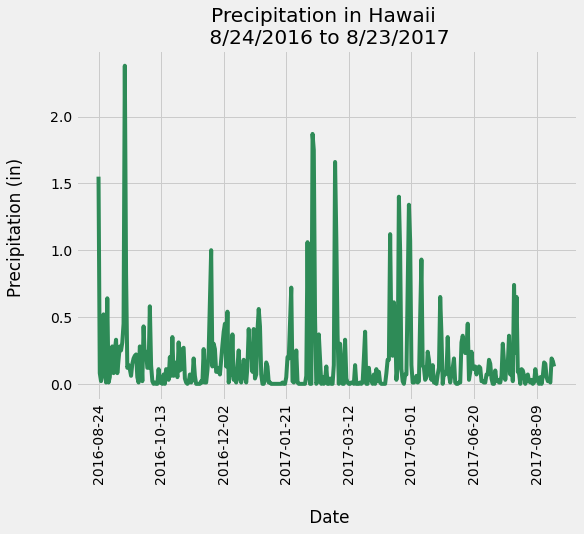

In [213]:
# Use Pandas Plotting with Matplotlib to plot the data
# precip = prcp_df.plot(kind = "line", figsize = (8, 6), 
#                      title = "Precipitation in Hawaii \n 8/24/2016 to 8/23/2017", 
#                      legend = False, use_index=True, color = "seagreen", rot = 90)

precip = prcp_df.plot(kind = "line", figsize = (8, 6), 
                     title = "Precipitation in Hawaii \n 8/24/2016 to 8/23/2017", 
                     legend = False, color = "seagreen", rot = 90)

x_axis = np.arange(len(dates))
precip.set_xlabel("\n Date" )
precip.set_ylabel("Precipitation (in) \n")
# tick_locations = [value+0.4 for value in x_axis]
# ax.set_xlim(-0.75, len(x_axis) -0.25)
# ax.set_ylim(0,max(prcp)+25) 
# plt.xticks(tick_locations, prcp_df[dates], rotation = "vertical"
                   

In [226]:
prcp_df.index.dtype

dtype('O')

In [282]:
#I am also plotting montly averages over time (using pandas), as an alterate way to visualize this data: 
#first, make copy of df 
prcp2_df = prcp_df.copy()

#convert index to datetime
prcp2_df.index = pd.to_datetime(prcp2_df.index)

#define column name for the index
prcp2_df["Date"] = prcp2_df.index
prcp2_df['Month-Year'] = pd.to_datetime(prcp2_df['Date']).dt.to_period('M')

mon_gb = prcp2_df.groupby(prcp2_df["Month-Year"]).mean()
mon_gb


,Precip (in)
Month-Year,
2016-08,0.390000
2016-09,0.280667
2016-10,0.120323
2016-11,0.131000
2016-12,0.199677
2017-01,0.075806
2017-02,0.226429
2017-03,0.157419
2017-04,0.315000


In [276]:
##CODE THAT DIDNT WORK FOR ME 

##this returned the precip  monthly averate, but the date was presented as teh last day of each month,
## rather than month and year, which seemed strange 
# prcp_mon = prcp2_df.resample("M").mean()
# prcp_mon
# prcp_mon

## Below doesn't return an error, but doesn't return what I wanted
# prcp2_df['Year-Month'] = str(prcp2_df.index.year) + "-" + str(prcp2_df.index.month) 
## For below, you would need to define getYearMonth first and I don't understand that syntax 
# prcp2_df['YearMonth']= prcp2_df['Date'].apply(lambda x: getYearMonth(x))

## Below doesn't work- some sort of databype error I think: 
# prcp_df.index = pd.to_datetime(prcp_df.index, format='%yyyy-%mm-%dd')
# prcp_df.index =prcp_df.datetime.strptime(prcp_df.index, format='%yyyy-%mm-%dd')

Text(0, 0.5, 'Average Monthly Precipitation (in) \n')

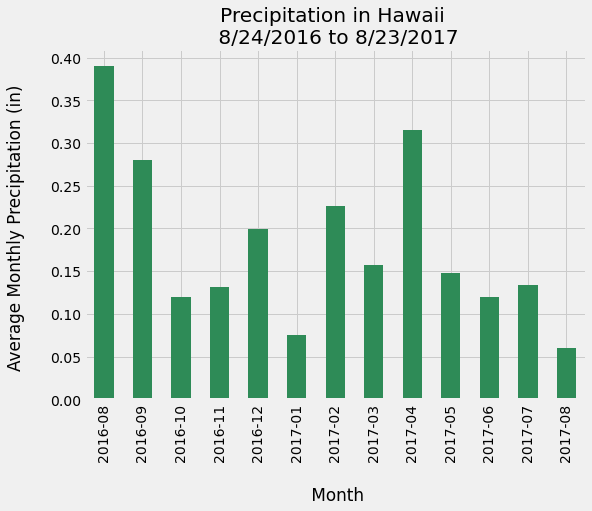

In [287]:
precip_mon = mon_gb.plot(kind = "bar", figsize = (8, 6), 
                     title = "Precipitation in Hawaii \n 8/24/2016 to 8/23/2017", 
                     legend = False, color = "seagreen", rot = 90)

x_axis = np.arange(len(dates))
precip_mon.set_xlabel("\n Month" )
precip_mon.set_ylabel("Average Monthly Precipitation (in) \n")

In [288]:
# Use Pandas to calcualte the summary statistics for the precipitation data
# Performing statistics on daily averages, using prcp_df
prcp_df[["Precip (in)"]].describe()


,Precip (in)
count,365.000000
mean,0.170219
std,0.295826
min,0.000000
25%,0.010000
50%,0.070000
75%,0.190000
max,2.380000


In [293]:
# Design a query to show how many stations are available in this dataset?
# use distinct

sta_count = session.query(station).group_by(station.station).count()
sta_count

9

In [ ]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
#count and group_by stations





In [ ]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?


In [ ]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
